#Case Study: Divvy Exercise Full Year Analysis

The purpose of this notebook is to conduct an analysis for the Google Data Analysis Capstone Project on Coursera. In this case study I was provided data from a bike-share company called Divvy. In order to answer the key business questions, I will follow the steps of the Data Analysis Process: Act, Prepare, Process, Analyze, Share and Act.

**The Business Task**

Analyze riding patterns from the 2023 Divvy trip data to understand how casual vs member riders use Divvy bikes differently.

**Description of Data Sources Used**

I used twelve-months of historical Divvy trip dataset to perform this analysis. This includes twelve different files each containing a month of data ranging from Jan 2023 - Dec 2023. The data is public and has been made available by Motivate International Inc. under this [License](https://ride.divvybikes.com/data-license-agreement).

In [2]:
#Load the required packages
import pandas as pd
from pandas.api.types import CategoricalDtype
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from haversine import haversine, Unit
import seaborn as sns

#Step 1: Load data and merge into a single dataframe

In [3]:
df1 = pd.read_csv('202301-divvy-tripdata.csv')
df2 = pd.read_csv('202302-divvy-tripdata.csv')
df3 = pd.read_csv('202303-divvy-tripdata.csv')
df4 = pd.read_csv('202304-divvy-tripdata.csv')
df5 = pd.read_csv('202305-divvy-tripdata.csv')
df6 = pd.read_csv('202306-divvy-tripdata.csv', on_bad_lines='skip')
df7 = pd.read_csv('202307-divvy-tripdata.csv')
df8 = pd.read_csv('202308-divvy-tripdata.csv')
df9 = pd.read_csv('202309-divvy-tripdata.csv')
df10 = pd.read_csv('202310-divvy-tripdata.csv')
df11 = pd.read_csv('202311-divvy-tripdata.csv')
df12 = pd.read_csv('202312-divvy-tripdata.csv')

In [4]:
#Merge all months into a single dataframe then show the data type of each column
divvy_2023 = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12], ignore_index=True)
divvy_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6398445 entries, 0 to 6398444
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 634.6+ MB


#Step 2: Cleaning and manipulation of data

In [5]:
# Get duplicates
duplicates = divvy_2023.duplicated()

#Remove Duplicates
divvy_2023 = divvy_2023.drop_duplicates()

divvy_2023.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,F96D5A74A3E41399,electric_bike,2023-01-21 20:05:42,2023-01-21 20:16:33,Lincoln Ave & Fullerton Ave,TA1309000058,Hampden Ct & Diversey Ave,202480.0,41.924074,-87.646278,41.930000,-87.640000,member
1,13CB7EB698CEDB88,classic_bike,2023-01-10 15:37:36,2023-01-10 15:46:05,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member
2,BD88A2E670661CE5,electric_bike,2023-01-02 07:51:57,2023-01-02 08:05:11,Western Ave & Lunt Ave,RP-005,Valli Produce - Evanston Plaza,599,42.008571,-87.690483,42.039742,-87.699413,casual
3,C90792D034FED968,classic_bike,2023-01-22 10:52:58,2023-01-22 11:01:44,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member
4,3397017529188E8A,classic_bike,2023-01-12 13:58:01,2023-01-12 14:13:20,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member


In [6]:
#Check for total number of null values in each column
divvy_2023.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 1
ended_at                   2
start_station_name    875719
start_station_id      875851
end_station_name      929205
end_station_id        929346
start_lat                  4
start_lng                  4
end_lat                 6994
end_lng                 6994
member_casual              4
dtype: int64

In [7]:
#Drop null values only in started_at, ended_at, and member_casual columns
divvy_2023.dropna(subset=['started_at','ended_at','member_casual'], inplace=True)

#Drop unecessary columns as these will not be helpful in answering the business task
divvy_2023 = divvy_2023.drop(['start_station_name', 'start_station_id','end_station_name','end_station_id'], axis=1)

#Check null values in each column once again
divvy_2023.isnull().sum()

ride_id             0
rideable_type       0
started_at          0
ended_at            0
start_lat           0
start_lng           0
end_lat          6990
end_lng          6990
member_casual       0
dtype: int64

In [8]:
#Change types for columns from object to str/int for consistency
divvy_2023['ride_id'] = divvy_2023['ride_id'].astype(str)
divvy_2023['rideable_type'] = divvy_2023['rideable_type'].astype(str)
divvy_2023['started_at'] = pd.to_datetime(divvy_2023['started_at'])
divvy_2023['ended_at'] = pd.to_datetime(divvy_2023['ended_at'])
divvy_2023['member_casual'] = divvy_2023['member_casual'].astype(str)

divvy_2023.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5719882 entries, 0 to 6398444
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ride_id        object        
 1   rideable_type  object        
 2   started_at     datetime64[ns]
 3   ended_at       datetime64[ns]
 4   start_lat      float64       
 5   start_lng      float64       
 6   end_lat        float64       
 7   end_lng        float64       
 8   member_casual  object        
dtypes: datetime64[ns](2), float64(4), object(3)
memory usage: 436.4+ MB


In [9]:
# Rename columns
divvy_2023 = divvy_2023.rename(columns={'rideable_type':'bike_type', 'member_casual':'customer_type'})

# Change 'docked_bike' to 'classic_bike' to make the data consistent
divvy_2023['bike_type'] = divvy_2023['bike_type'].replace(['docked_bike'],'classic_bike')

In [10]:
# Add columns that list the date, month, day, and year of each ride
# This will allow us to aggregate ride data for each month, day, or year
divvy_2023['day'] = divvy_2023['started_at'].dt.dayofweek.astype(int)
divvy_2023['hour'] = divvy_2023['started_at'].dt.hour
divvy_2023['month'] = divvy_2023['started_at'].dt.month_name()
divvy_2023['day_of_week'] = divvy_2023['started_at'].dt.day_name()

#Check if it is weekend
divvy_2023["weekend"] = 'No'
divvy_2023.loc[divvy_2023['day_of_week'] == 'Saturday', 'weekend'] = 'Yes'
divvy_2023.loc[divvy_2023['day_of_week'] == 'Sunday', 'weekend'] = 'Yes'

In [11]:
#Create new column called ride length
divvy_2023['ride_length'] = (divvy_2023['ended_at']- divvy_2023['started_at']).dt.total_seconds()

print("Minimum ride_length : ", divvy_2023['ride_length'].min())
print("Maximum ride_length : ", divvy_2023['ride_length'].max())

Minimum ride_length :  -999391.0000000001
Maximum ride_length :  5909344.0


In [12]:
#Filter dataframe to remove all rides that have negative trip length
divvy_2023 = divvy_2023[divvy_2023['ride_length'] > 0]

#Compute distance in km using Haversine formula and start_lng, start_lat, end_lng, and end_lat columns
def cal_distance(row):
    start_location = (row['start_lat'], row['start_lng'])
    end_location = (row['end_lat'], row['end_lng'])
    return haversine(start_location, end_location, unit=Unit.KILOMETERS)

divvy_2023['distance_km'] = divvy_2023.apply(cal_distance, axis=1)

In [13]:
#remove started_at, ended_at, lat and long columns as they are no longer needed
divvy_2023 = divvy_2023.drop(['started_at','ended_at','start_lng', 'start_lat', 'end_lng', 'end_lat'], axis=1)
divvy_2023.head()

,ride_id,bike_type,customer_type,day,hour,month,day_of_week,weekend,ride_length,distance_km
0,F96D5A74A3E41399,electric_bike,member,5,20,January,Saturday,Yes,651.0,0.839043
1,13CB7EB698CEDB88,classic_bike,member,1,15,January,Tuesday,No,509.0,1.204575
2,BD88A2E670661CE5,electric_bike,casual,0,7,January,Monday,No,794.0,3.543687
3,C90792D034FED968,classic_bike,member,6,10,January,Sunday,Yes,526.0,1.204575
4,3397017529188E8A,classic_bike,member,3,13,January,Thursday,No,919.0,1.204575


#Step 3: Exploratory Data Analysis

C:\Users\giris\AppData\Local\Temp\ipykernel_14500\3720303520.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


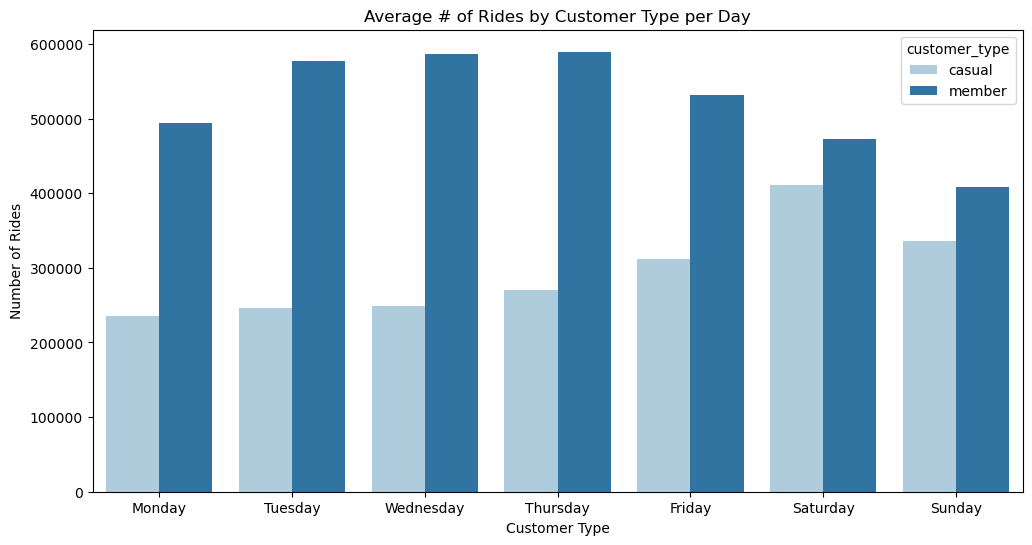

In [14]:
#Find weekly average number of rides for casual vs members
divvy_2023_num_rides = divvy_2023.groupby(['day_of_week', 'day', 'customer_type'])['ride_length'].count().reset_index()
divvy_2023_num_rides = divvy_2023_num_rides.rename(columns={'ride_length':'daily_rides'}).sort_values(by='day')
divvy_2023_num_rides

#Visualize
sns.set_palette('Paired')
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=divvy_2023_num_rides, hue='customer_type', y='daily_rides', x='day_of_week')
ax.set_title('Average # of Rides by Customer Type per Day')
ax.set_xlabel('Customer Type')
ax.set_ylabel('Number of Rides')
fig.show()

   day_of_week  day customer_type  daily_ride_length
2       Monday    0        casual        1663.254479
3       Monday    0        member         714.254121
10     Tuesday    1        casual        1505.379112
11     Tuesday    1        member         720.911192
12   Wednesday    2        casual        1458.636671
13   Wednesday    2        member         716.946719
8     Thursday    3        casual        1483.894001
9     Thursday    3        member         721.293491
0       Friday    4        casual        1636.137245
1       Friday    4        member         748.834639
4     Saturday    5        casual        1928.708079
5     Saturday    5        member         836.446479
6       Sunday    6        casual        1972.105444
7       Sunday    6        member         839.553330


C:\Users\giris\AppData\Local\Temp\ipykernel_14500\4124351548.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


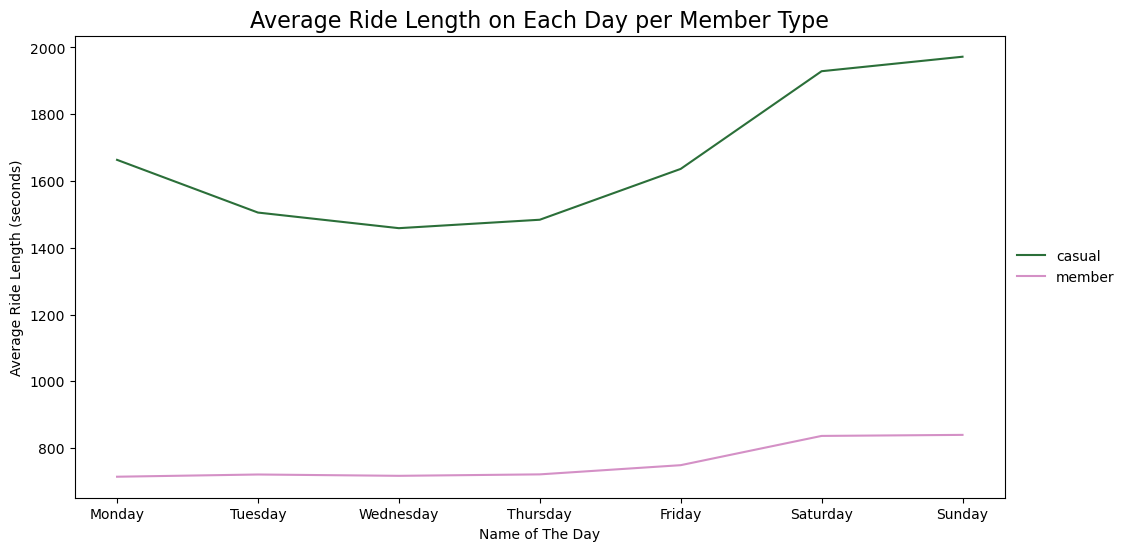

In [15]:
#Find daily average ride length of rides for casual vs members

divvy_2023_daily_ride_length = divvy_2023.groupby(['day_of_week','day','customer_type'])['ride_length'].mean().reset_index()
divvy_2023_daily_ride_length = divvy_2023_daily_ride_length.rename(columns={'ride_length':'daily_ride_length'}).sort_values(by='day')
print(divvy_2023_daily_ride_length)

# Visualization
fig2, ax2 = plt.subplots(figsize=(12,6))
sns.lineplot(x='day_of_week',y='daily_ride_length', hue='customer_type', data=divvy_2023_daily_ride_length, palette='cubehelix')
ax2.set_title('Average Ride Length on Each Day per Member Type', fontsize='16')
ax2.set_xlabel('Name of The Day')
ax2.set_ylabel('Average Ride Length (seconds)')
ax2.legend(frameon=False, bbox_to_anchor=(1,0.5), loc='center left')
fig2.show()

   day_of_week  day customer_type  daily_ride_length
2       Monday    0        casual        1663.254479
3       Monday    0        member         714.254121
10     Tuesday    1        casual        1505.379112
11     Tuesday    1        member         720.911192
12   Wednesday    2        casual        1458.636671
13   Wednesday    2        member         716.946719
8     Thursday    3        casual        1483.894001
9     Thursday    3        member         721.293491
0       Friday    4        casual        1636.137245
1       Friday    4        member         748.834639
4     Saturday    5        casual        1928.708079
5     Saturday    5        member         836.446479
6       Sunday    6        casual        1972.105444
7       Sunday    6        member         839.553330


C:\Users\giris\AppData\Local\Temp\ipykernel_14500\3118883552.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


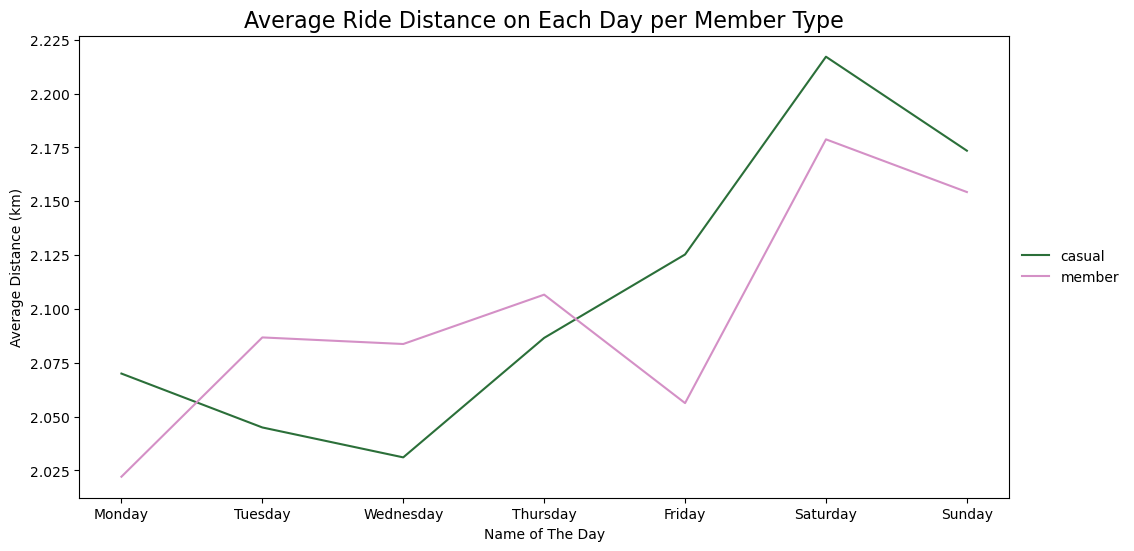

In [17]:
#Find daily average distance for casual vs members

divvy_2023_daily_distance = divvy_2023.groupby(['day_of_week','day','customer_type'])['distance_km'].mean().reset_index()
divvy_2023_daily_distance = divvy_2023_daily_distance.rename(columns={'distance_km':'daily_distance'}).sort_values(by='day')
print(divvy_2023_daily_ride_length)

# Visualization
fig2, ax2 = plt.subplots(figsize=(12,6))
sns.lineplot(x='day_of_week',y='daily_distance', hue='customer_type', data=divvy_2023_daily_distance, palette='cubehelix')
ax2.set_title('Average Ride Distance on Each Day per Member Type', fontsize='16')
ax2.set_xlabel('Name of The Day')
ax2.set_ylabel('Average Distance (km)')
ax2.legend(frameon=False, bbox_to_anchor=(1,0.5), loc='center left')
fig2.show()